In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rcParams['font.size'] = 6
plt.rcParams['figure.figsize'] = (6,6)

from collections import Counter

import pandas as pd
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D
# from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.layers import Dense
from keras.applications import ResNet50
# from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

from keras.preprocessing.image import array_to_img, img_to_array, load_img
from scipy.misc import imresize

from sklearn.model_selection import train_test_split

Using TensorFlow backend.



# 数据预处理部分


In [35]:
ratings = pd.read_excel('SCUT-FBP5500_with_Landmarks/All_Ratings.xlsx')
ratings.head()

,Email,Filename,Rating,original Rating
0,1,ftw1.jpg,3,NaN
1,1,ftw10.jpg,3,NaN
2,1,ftw100.jpg,1,NaN
3,1,ftw101.jpg,2,NaN
4,1,ftw102.jpg,3,NaN


In [36]:
filenames = ratings.groupby('Filename').size().index.tolist()

labels = []

for filename in filenames:
    df = ratings[ratings['Filename'] == filename]
    count = Counter(df['Rating']).most_common(1)[0][0]
    score = round(df['Rating'].mean(), 2)
    labels.append({'Filename': filename, 'most_common': count, 'score': score})

labels_df = pd.DataFrame(labels)
labels_df.head()

,Filename,most_common,score
0,ftw1.jpg,4,4.12
1,ftw10.jpg,3,3.55
2,ftw100.jpg,2,2.13
3,ftw101.jpg,3,2.48
4,ftw102.jpg,3,3.30


In [63]:
scores = sorted(labels_df.score.tolist())

<Container object of 9 artists>

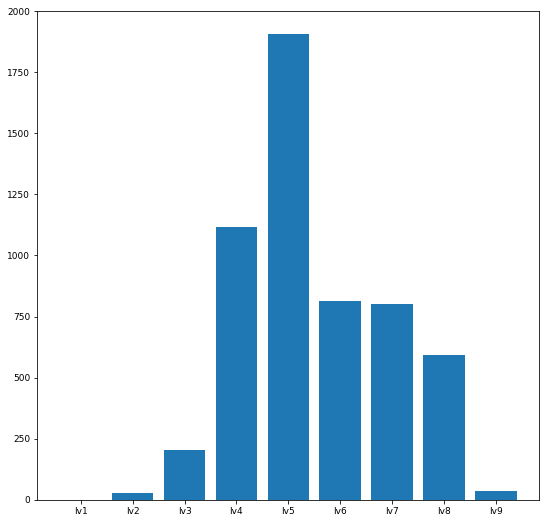

In [69]:
lv1 = [x for x in scores if x<1]
lv2 = [x for x in scores if x>=1 and x<1.5]
lv3 = [x for x in scores if x>=1.5 and x<2]
lv4 = [x for x in scores if x>=2 and x<2.5]
lv5 = [x for x in scores if x>=2.5 and x<3]
lv6 = [x for x in scores if x>=3 and x<3.5]
lv7 = [x for x in scores if x>=3.5 and x<4]
lv8 = [x for x in scores if x>=4 and x<4.5]
lv9 = [x for x in scores if x>=4.5]
plt.bar(['lv1','lv2','lv3','lv4','lv5','lv6','lv7','lv8','lv9'],
       [len(x) for x in [lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9]])

In [5]:
img_width, img_height, channels = 350, 350, 3
sample_dir = 'SCUT-FBP5500_with_Landmarks/Images/'
nb_samples = len(os.listdir(sample_dir))
input_shape = (img_width, img_height, channels)

x_total = np.empty((nb_samples, img_width, img_height, channels), dtype=np.float32)
y_total = np.empty((nb_samples, 1), dtype=np.float32)

for i, fn in enumerate(os.listdir(sample_dir)):
    img = load_img('%s/%s' % (sample_dir, fn))
    x = img_to_array(img).reshape(img_height, img_width, channels)
    x = x.astype('float32') / 255.
    y = labels_df[labels_df.Filename == fn].score.values
    y = y.astype('float32')
    x_total[i] = x
    y_total[i] = y

In [6]:
seed = 42
x_train_all, x_test, y_train_all, y_test = train_test_split(x_total, y_total, test_size=0.2, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=seed)

In [7]:
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

In [8]:
for item in [x_train, y_train, x_val, y_val, x_test, y_test]:
    print(item.shape)

(3520, 350, 350, 3)
(3520, 1)
(880, 350, 350, 3)
(880, 1)
(1100, 350, 350, 3)
(1100, 1)



# 训练


In [2]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

In [4]:
for item in [x_train, y_train, x_val, y_val]:
    print(item.shape)

(3520, 350, 350, 3)
(3520, 1)
(880, 350, 350, 3)
(880, 1)


In [6]:
img_width, img_height, channels = 350, 350, 3
input_shape = (img_width, img_height, channels)

In [7]:
resnet = ResNet50(include_top=False, pooling='avg', input_shape=input_shape)
model = Sequential()
model.add(resnet)
model.add(Dense(1))
model.layers[0].trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(batch_size=32, x=x_train, y=y_train, epochs=30)

Epoch 1/30
3520/3520 [==============================] - 26s 7ms/step - loss: 1.1063
Epoch 2/30
3520/3520 [==============================] - 24s 7ms/step - loss: 0.3785
Epoch 3/30
3520/3520 [==============================] - 24s 7ms/step - loss: 0.3207
Epoch 4/30
3520/3520 [==============================] - 24s 7ms/step - loss: 0.2787
Epoch 5/30
3520/3520 [==============================] - 24s 7ms/step - loss: 0.2363
Epoch 6/30
3520/3520 [==============================] - 24s 7ms/step - loss: 0.2318
Epoch 7/30
3520/3520 [==============================] - 24s 7ms/step - loss: 0.2180
Epoch 8/30
3520/3520 [==============================] - 24s 7ms/step - loss: 0.1955
Epoch 9/30
3520/3520 [==============================] - 24s 7ms/step - loss: 0.1869
Epoch 10/30
3520/3520 [==============================] - 24s 7ms/step - loss: 0.1908
Epoch 11/30
3520/3520 [==============================] - 24s 7ms/step - loss: 0.1871
Epoch 12/30
3520/3520 [==============================] - 24s 7ms/step - lo

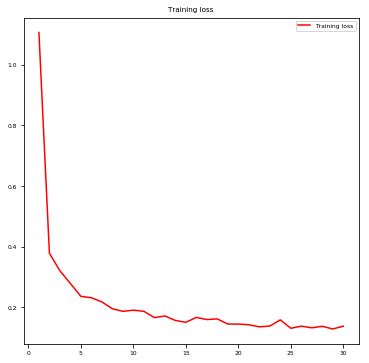

In [9]:
plt.rcParams['figure.figsize'] = (6,6)

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.title('Training loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.legend()

plt.show()

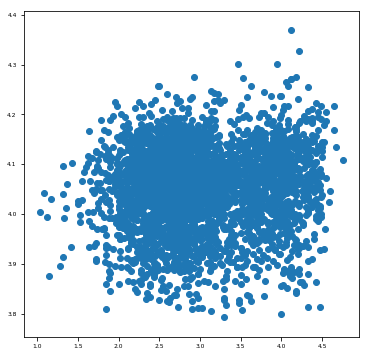

In [10]:
plt.scatter(y_train, model.predict(x_train))

In [17]:
filepath="{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
callback_list = [checkpoint, reduce_learning_rate]

In [18]:
model.layers[0].trainable = True
model.compile(loss='mse', optimizer='adam')
history = model.fit(x=x_train, 
                    y=y_train, 
                    batch_size=8,
                    epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=callback_list)

Train on 3520 samples, validate on 880 samples
Epoch 1/10
3520/3520 [==============================] - 88s 25ms/step - loss: 0.3055 - val_loss: 0.4171

Epoch 00001: val_loss improved from inf to 0.41706, saving model to 01-0.42.h5
Epoch 2/10
3520/3520 [==============================] - 84s 24ms/step - loss: 0.1951 - val_loss: 0.4226

Epoch 00002: val_loss did not improve
Epoch 3/10
3520/3520 [==============================] - 84s 24ms/step - loss: 0.1632 - val_loss: 0.2787

Epoch 00003: val_loss improved from 0.41706 to 0.27870, saving model to 03-0.28.h5
Epoch 4/10
3520/3520 [==============================] - 84s 24ms/step - loss: 0.1417 - val_loss: 0.1871

Epoch 00004: val_loss improved from 0.27870 to 0.18708, saving model to 04-0.19.h5
Epoch 5/10
3520/3520 [==============================] - 84s 24ms/step - loss: 0.1536 - val_loss: 0.1794

Epoch 00005: val_loss improved from 0.18708 to 0.17943, saving model to 05-0.18.h5
Epoch 6/10
3520/3520 [==============================] - 84s 24

In [20]:
from keras.models import load_model

best_model = load_model('06-0.15.h5')

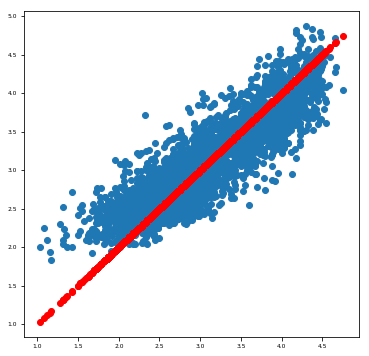

In [21]:
plt.scatter(y_train, best_model.predict(x_train))
plt.plot(y_train, y_train, 'ro')

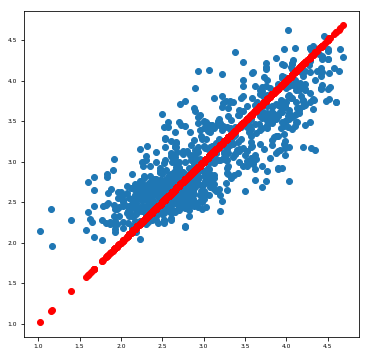

In [24]:
plt.scatter(y_val, best_model.predict(x_val))
plt.plot(y_val, y_val, 'ro')

In [25]:
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [26]:
best_model.evaluate(x=x_test, y=y_test)

1100/1100 [==============================] - 10s 9ms/step


0.16454477965831757

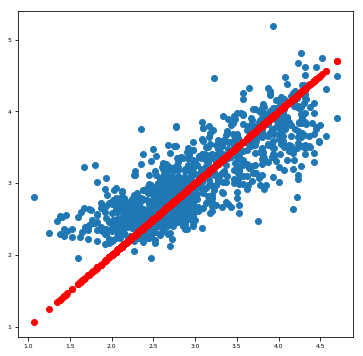

In [27]:
plt.scatter(y_test, best_model.predict(x_test))
plt.plot(y_test, y_test, 'ro')

In [70]:
scores = best_model.predict(x_test)
scores = [x[0] for x in scores.tolist()]

<Container object of 9 artists>

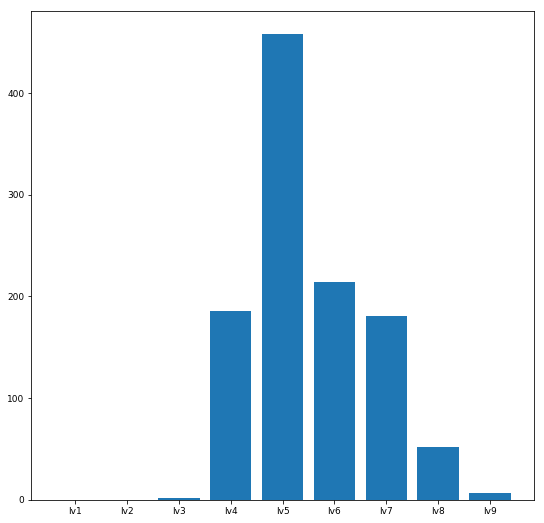

In [83]:
lv1 = [x for x in scores if x<1]
lv2 = [x for x in scores if x>=1 and x<1.5]
lv3 = [x for x in scores if x>=1.5 and x<2]
lv4 = [x for x in scores if x>=2 and x<2.5]
lv5 = [x for x in scores if x>=2.5 and x<3]
lv6 = [x for x in scores if x>=3 and x<3.5]
lv7 = [x for x in scores if x>=3.5 and x<4]
lv8 = [x for x in scores if x>=4 and x<4.5]
lv9 = [x for x in scores if x>=4.5]
plt.bar(['lv1','lv2','lv3','lv4','lv5','lv6','lv7','lv8','lv9'],
       [len(x) for x in [lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9]])

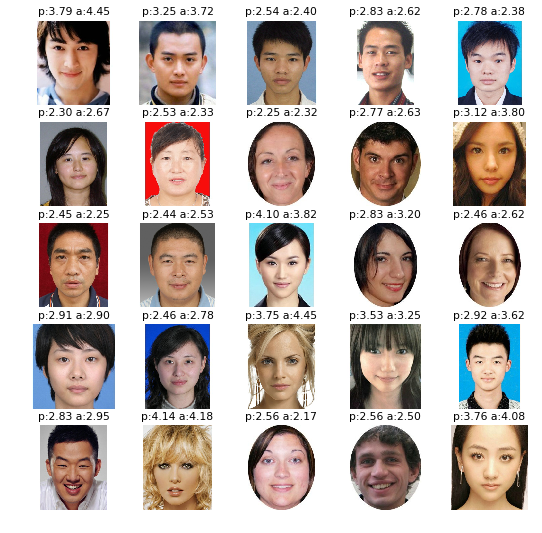

In [55]:
plt.rcParams['font.size'] = 9
plt.rcParams['figure.figsize'] = (9,9)

from random import randint
nb_test_samples = x_test.shape[0]
nb_rows, nb_cols = 5, 5

def check_test_result():
    for k in range(nb_rows * nb_cols):
        i = randint(0, nb_test_samples - 1)
        predicted = best_model.predict(x_test[i].reshape((1,) + x_test[i].shape))
        plt.subplot(nb_rows, nb_cols, k+1)
        plt.imshow(x_test[i])
        plt.title("p:%.2f a:%.2f" % (predicted[0][0], y_test[i]))
        plt.axis('off')

check_test_result()

predicted: 3.53


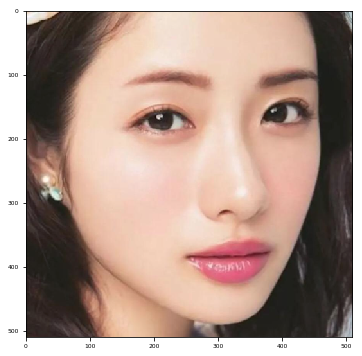

In [53]:
plt.rcParams['font.size'] = 6
plt.rcParams['figure.figsize'] = (6,6)

img = load_img('ishihara.png')
plt.imshow(img)
img = imresize(img, size=(img_height, img_width))
test_x = img_to_array(img).reshape(img_height, img_width, channels)
test_x = test_x / 255.
test_x = test_x.reshape((1,) + test_x.shape)
predicted = best_model.predict(test_x)
print("predicted: %.2f" % predicted[0][0])